**TimeSeriesKMeans-DTW based Vessel Trajectory Clustering Analysis**

This notebook performs TimeSeriesKMeans with Dynamic Time Warping (DTW) clustering analysis on AIS (Automatic Identification System) vessel trajectories in US waters during 2024. It identifies representative vessel movement patterns (medoids) that can be integrated with the Flask web application for visualization.

In [42]:
# Imports and Environment Verification
import warnings
warnings.filterwarnings("ignore", message="h5py not installed")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import sys
import os
from dotenv import load_dotenv
print(f"Python executable: {sys.executable}")
print(f"Virtual environment active: {'venv' in sys.executable}")

# Load environment variables from .env file
load_dotenv()
print("Environment variables loaded from .env file")

import psycopg2
from psycopg2.extras import RealDictCursor
import pandas as pd
import numpy as np
from tabulate import tabulate
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
import matplotlib.pyplot as plt
import time
from datetime import datetime

print("All modules imported successfully!")

Python executable: c:\Users\Jorge\Projects\unipi-ds-charikiopoulos-thesis\venv\Scripts\python.exe
Virtual environment active: True
Environment variables loaded from .env file
All modules imported successfully!


In [43]:
# Load vessel trajectory data from the database for DTW clustering analysis

# Database connection using environment variables
conn = psycopg2.connect(
    host=os.getenv('DB_HOST', 'localhost'),
    database=os.getenv('DB_NAME', 'postgres'),
    user=os.getenv('DB_USER', 'postgres'),
    password=os.getenv('DB_PASSWORD'),
    port=os.getenv('DB_PORT', '5432')
)

cursor = conn.cursor(cursor_factory=RealDictCursor)
    
query = """
SELECT
    mmsi,
    lat,
    lon,
    datetime_utc,
    utm_x,
    utm_y,
    CASE
        WHEN vessel_type = 30 THEN 'fishing'
        WHEN vessel_type BETWEEN 60 AND 69 THEN 'passenger'
        WHEN vessel_type BETWEEN 70 AND 79 THEN 'cargo'
        WHEN vessel_type BETWEEN 80 AND 89 THEN 'tanker'
    END AS vessel_category
FROM
    vessel_trajectories_gulf_2024
WHERE
    (
        vessel_type = 30
        OR (vessel_type BETWEEN 60 AND 69)
        OR (vessel_type BETWEEN 70 AND 79)
        OR (vessel_type BETWEEN 80 AND 89)
    )
ORDER BY
    mmsi,
    datetime_utc ASC
;
"""

cursor.execute(query)
data = cursor.fetchall()
cursor.close()
conn.close()

df = pd.DataFrame(data)
print(f"Raw query result length: {len(data)}")
print(f"DataFrame length: {len(df)}")

# Display basic information about the dataset
print(f"\nDataset Overview:")
print(f"- Unique vessels (MMSIs): {df['mmsi'].nunique()}")
print(f"- Date range: {df['datetime_utc'].min()} to {df['datetime_utc'].max()}")
print(f"- Vessel categories: {df['vessel_category'].unique()}")
print("=" * 50)

Raw query result length: 1344790
DataFrame length: 1344790

Dataset Overview:
- Unique vessels (MMSIs): 702
- Date range: 2024-01-01 00:00:00 to 2024-12-31 23:59:05
- Vessel categories: ['cargo' 'tanker' 'passenger' 'fishing']


In [24]:
# Group by MMSI and display the first group

grouped = df.groupby("mmsi")

grouped_by_type = df.groupby("vessel_category")
tabulated = []

for vessel_category, group in grouped_by_type:
    tabulated.append([vessel_category, "{:,}".format(len(group))])

print(tabulate(tabulated, headers=["vessel_category", "number_of_positions"]))

vessel_category    number_of_positions
-----------------  ---------------------
cargo              380,385
fishing            451,879
passenger          346,188
tanker             166,338


In [25]:
# Function to resample trajectory data for each group
# This function takes a DataFrame group and returns a resampled trajectory
# with a specified number of points, interpolating missing values

def resample_trajectory(df_group, num_points=100):
    df_sorted = df_group.sort_values("datetime_utc").set_index("datetime_utc")
    df_sorted = df_sorted[["utm_x", "utm_y"]]
    
    # Create uniform timestamps between first and last
    new_index = pd.date_range(df_sorted.index.min(), df_sorted.index.max(), periods=num_points)
    
    # Reindex and interpolate
    df_resampled = df_sorted.reindex(new_index).interpolate(method="time")
    
    return df_resampled.values  # returns a (num_points, 2) numpy array


In [26]:
# Resample trajectories for each group and store them in a list
# this will create a list of numpy arrays, each representing a trajectory
# with 100 points (lat, lon)

trajectories = []
vessel_ids = []

for mmsi, group in grouped:
    try:
        traj = resample_trajectory(group)
        if traj.shape == (100, 2):  # ensure consistent shape
            trajectories.append(traj)
            vessel_ids.append(mmsi)
    except Exception as e:
        print(f"Skipping {mmsi}: {e}")

print(f"Collected {len(trajectories)} trajectories ({len(vessel_ids)} vessels).\n")
#print(f"First vessel ID: {vessel_ids[0]}")
#print(f"First trajectory shape:\n{trajectories[0]}")

Collected 702 trajectories (702 vessels).



In [27]:
# Convert the list of trajectories to a numpy array
# Each trajectory is a numpy array of shape (100, 2)

X = np.array(trajectories)
print("Shape of numpy array X:", X.shape)

Shape of numpy array X: (702, 100, 2)


In [28]:
# Calculate the DTW distances between all pairs of trajectories
# This will create a distance matrix where each entry (i, j) is the DTW
from tslearn.metrics import cdist_dtw
distances = cdist_dtw(X)

In [29]:
# DTW Clustering Helper Functions

# Silhouette score function using DTW
def silhouette_score_dtw(X, labels, distances=None):
    """
    Calculate silhouette score using pre-computed DTW distance matrix.
    
    Args:
        X: Array of trajectories (not used directly, kept for compatibility)
        labels: Cluster labels for each trajectory
        distances: Pre-computed DTW distance matrix
    
    Returns:
        Mean silhouette score for each cluster, across all trajectories
    """
    n_samples = len(X)
    unique_labels = np.unique(labels)

    silhouette_scores = []
    for i in range(n_samples):
        same_cluster = labels == labels[i]
        a = np.mean(distances[i][same_cluster]) if np.sum(same_cluster) > 1 else 0
        b = np.min([
            np.mean(distances[i][labels == other_label])
            for other_label in unique_labels if other_label != labels[i]
        ])
        silhouette_scores.append((b - a) / max(a, b) if max(a, b) > 0 else 0)

    return np.mean(silhouette_scores)

# Function to find the medoid indices for each cluster
def find_medoid_indices(X, labels, cluster_index):
    """
    Find the medoid (most representative trajectory) for a given cluster.
    
    Args:
        X: Array of all trajectories
        labels: Cluster labels for each trajectory
        cluster_index: Which cluster to find medoid for
    
    Returns:
        Index of the medoid trajectory in the original array
    """
    indices = [i for i, lbl in enumerate(labels) if lbl == cluster_index]
    cluster_trajectories = [X[i] for i in indices]

    total_dtw = []
    for i, t1 in enumerate(cluster_trajectories):
        dist_sum = sum(dtw(t1, t2) for j, t2 in enumerate(cluster_trajectories) if i != j)
        total_dtw.append(dist_sum)

    medoid_idx = indices[np.argmin(total_dtw)]
    return medoid_idx

In [35]:
# Run clustering and evaluation for different values of k
# This will iterate over a range of k values and perform clustering
# evaluate the silhouette score, and find medoids for each cluster

# Setup
k_values = range(2, 7)  # for k from 2 to 6
silhouette_scores = {}
cluster_models = {}
cluster_labels = {}
cluster_medoids = {}
medoid_vessels_by_k = {}

best_score = -1  # Minimum possible silhouette score is -1
best_k = None
best_labels = None
best_medoids = None
best_medoids_mmsi = None

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Start timer
start_time = time.time()
start_dt = datetime.now()
print(f"Started DTW clustering analysis at: {start_dt.strftime('%H:%M:%S')}")
print(f"Processing k values: {list(k_values)}")
print("-" * 50)

# Main loop
for k in k_values:
    print(f"Processing k={k}...")
    
    # Use random_state for reproducible results - must be same as in numpy random seed
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=RANDOM_SEED, verbose=False)
    labels = model.fit_predict(X)

    score = silhouette_score_dtw(X, labels, distances)
    print(f"  Silhouette score for k={k}: {score:.4f}")

    medoid_indices = [find_medoid_indices(X, labels, i) for i in range(k)]
    medoid_mmsi = [vessel_ids[idx] for idx in medoid_indices]

    # Store results
    silhouette_scores[k] = score
    cluster_models[k] = model
    cluster_labels[k] = labels
    cluster_medoids[k] = medoid_indices
    medoid_vessels_by_k[k] = medoid_mmsi

    # Track best result
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
        best_medoids = medoid_indices
        best_medoids_mmsi = medoid_mmsi

# End timer
end_time = time.time()
end_dt = datetime.now()
duration = end_time - start_time

print("-" * 50)
print(f"Clustering analysis completed at: {end_dt.strftime('%H:%M:%S')}")
print(f"Total duration: {duration:.0f} seconds")
print(f"\nBEST RESULTS:")
print(f"  Best k: {best_k}")
print(f"  Best silhouette score: {best_score:.4f}")
print(f"  Medoid MMSIs: {best_medoids_mmsi}")
print("=" * 50)

Started DTW clustering analysis at: 02:23:57
Processing k values: [2, 3, 4, 5, 6]
--------------------------------------------------
Processing k=2...
  Silhouette score for k=2: 0.4143
Processing k=3...
  Silhouette score for k=3: 0.4375
Processing k=4...
  Silhouette score for k=4: 0.4451
Processing k=5...
  Silhouette score for k=5: 0.3431
Processing k=6...
  Silhouette score for k=6: 0.3427
--------------------------------------------------
Clustering analysis completed at: 02:28:15
Total duration: 259 seconds

BEST RESULTS:
  Best k: 4
  Best silhouette score: 0.4451
  Medoid MMSIs: [367321850, 368323490, 371557000, 367151590]


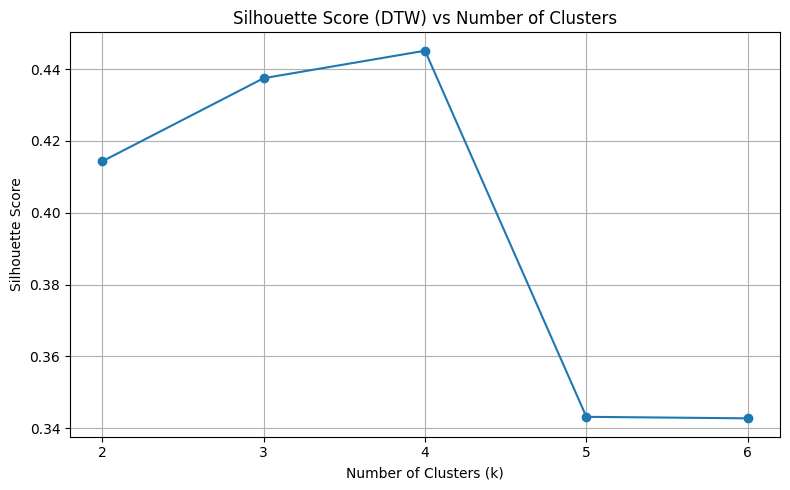

In [36]:
# Plot the silhouette scores for each k value
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Score (DTW) vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Count number of trajectories per cluster using best_labels
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
cluster_counts = cluster_counts.rename_axis("cluster").reset_index(name="vessel_count")

print(cluster_counts)

   cluster  vessel_count
0        0           281
1        1           286
2        2            34
3        3           101


In [39]:
# Export Medoids for Flask Application
# This cell formats the medoid MMSIs for easy copy-paste into the Flask application

print("=" * 60)
print("MEDOIDS EXPORT FOR FLASK APPLICATION")
print("=" * 60)

print(f"\n1. BEST CLUSTERING RESULTS:")
print(f"   Best k: {best_k}")
print(f"   Silhouette Score: {best_score:.4f}")
print(f"   Number of clusters: {len(best_medoids_mmsi)}")

print(f"\n2. MEDOID VESSEL IDs (MMSIs):")
print(f"   Copy these values to app/services/vessel_service.py")
print(f"   Replace the medoid_mmsis_array in fetch_medoids_trajectories()")

print("\n   Python list format:")
print("   medoid_mmsis_array = [")
for i, mmsi in enumerate(best_medoids_mmsi):
    comma = "," if i < len(best_medoids_mmsi) - 1 else ""
    print(f"       {mmsi}{comma}  # Medoid for cluster {i}")
print("   ]")
print("\n" + "=" * 60)

MEDOIDS EXPORT FOR FLASK APPLICATION

1. BEST CLUSTERING RESULTS:
   Best k: 4
   Silhouette Score: 0.4451
   Number of clusters: 4

2. MEDOID VESSEL IDs (MMSIs):
   Copy these values to app/services/vessel_service.py
   Replace the medoid_mmsis_array in fetch_medoids_trajectories()

   Python list format:
   medoid_mmsis_array = [
       367321850,  # Medoid for cluster 0
       368323490,  # Medoid for cluster 1
       371557000,  # Medoid for cluster 2
       367151590  # Medoid for cluster 3
   ]

